In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
# type d => <enter> => stopwords => <enter>
# type d => <enter> => wordnet => <enter> => q

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('gdrive/MyDrive/researchProjectIME/new_df_marked.csv')[:401]
df.drop_duplicates(subset=['tweet'])
print('Out of {} tweets, {} are demanding vaccines and {} are not.'.format(len(df), len(df[df['Imad'] == 1]), len(df[df['Imad'] == 0])))

Out of 401 tweets, 146 are demanding vaccines and 255 are not.


In [ ]:
import re
import string

def clean(txt: str):
  txt = re.sub(r'@[A-Za-z0-9_]+', '', txt)
  txt = re.sub(r'&amp', 'and', txt)
  txt = re.sub('#', '', txt)
  txt = re.sub(r'RT', '', txt)
  txt = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', txt)
  txt = ''.join([c for c in txt if c not in string.punctuation])
  txt = txt.lower()
  #for c in string.punctuation:
  #  txt = re.sub(c, '', txt)
  return txt

def tokenize(text: str):
  tokens = re.split('\W+', text)
  return tokens

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

def removeStopwords(tokens):
  ret = [token for token in tokens if token not in stopwords]
  ret = [token for token in tokens if token != '']
  return ret

In [ ]:
wn = nltk.WordNetLemmatizer()

def lemmatize(tokens):
  ret = [wn.lemmatize(token) for token in tokens]
  return ret

def finalClean(txt: str):
  return lemmatize(removeStopwords(tokenize(clean(txt))))

dDict = open('gdrive/MyDrive/researchProjectIME/data_dictionary.txt', 'r').read().split('\n')

def dictPercent(words):
  s = 0
  for word in words:
    if word in dDict:
      s += 1
  return 100 * s / len(words)

df['final'] = df['tweet'].apply(finalClean)
df['dict%'] = df['final'].apply(dictPercent)

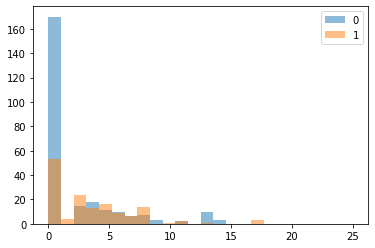

In [ ]:
bins = np.linspace(0, 25, 25)

import matplotlib.pyplot as plt
plt.hist(df[df['Imad']==0]['dict%'], bins, alpha=0.5, label='0')
plt.hist(df[df['Imad']==1]['dict%'], bins, alpha=0.5, label='1')
plt.legend(loc='upper right')
plt.show()

In [ ]:
df.to_csv('new_df_marked_cleaned.csv')

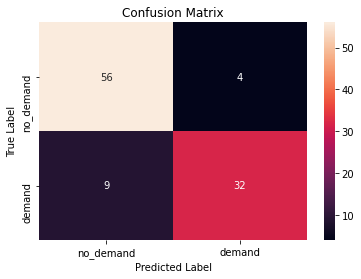

In [ ]:
#!pip list | grep scikit-learn || pip install scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score as acs
from sklearn.metrics import confusion_matrix
import seaborn as sns

X = df[['tweet', 'dict%']]
y = df['Imad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

countVect = CountVectorizer(analyzer=finalClean)
count_fit_train = countVect.fit_transform(X_train['tweet'])
count_fit_test = countVect.transform(X_test['tweet'])

X_train_vec = pd.DataFrame(count_fit_train.toarray())
X_test_vec = pd.DataFrame(count_fit_test.toarray())

rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)
rf_model = rf.fit(X_train_vec, y_train)
y_pred = rf_model.predict(X_test_vec)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label=1, average='binary')

cm = confusion_matrix(y_test, y_pred)
class_label = ["no_demand", "demand"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
print(precision, recall, fscore, acs(y_test, y_pred))

0.8888888888888888 0.7804878048780488 0.8311688311688312 0.8712871287128713


In [ ]:
df_pred = pd.read_csv('gdrive/MyDrive/researchProjectIME/new_df_marked.csv')[401:500]
X_to_pred = pd.DataFrame(countVect.transform(df_pred['tweet']).toarray())
y_to_pred = rf_model.predict(X_to_pred)
df_pred['predicted'] = y_to_pred
df_pred.to_csv('predicted.csv')

In [ ]:
def predict(text: str):
  df_pr = pd.DataFrame([[text]], columns=['tweet'])
  features = pd.DataFrame(countVect.transform(df_pr['tweet']).toarray())
  y_pr = rf_model.predict(features)
  return y_pr

In [ ]:
print(predict('want vaccine'))

[0.]


In [ ]:
df = pd.read_csv('gdrive/MyDrive/researchProjectIME/new_df_marked.csv')
print(len(df))
df.sort_values('tweet', inplace=True)
df.to_csv('delet1.csv')
df.drop_duplicates(subset='tweet', keep=False, inplace=True)
df.to_csv('delet2.csv')

500
